## Specifying the Problem

In [1]:
import qiskit #load the qiskit-terra library

In [2]:
secret_number = 12 #1100 in binary
number_of_bits = 4 #number of bis used for the secret number

## Specifying Quantum Registers
Registers of qubits are defined using the QuantumRegister class

In [3]:
from qiskit import QuantumRegister

In [4]:
# defines a 4-qubit register
qr = QuantumRegister(number_of_bits, name='qr')

# defines a 1-qubit register
qa = QuantumRegister(1, name='qa')

## Specifying a quantum circuit to prepare registers
The states of qubits are manipulated using quantum circuit gates. We use the QuantumCircuit object to define a circuit acting on registers, and use circuit methods to add gates to the circuit

In [5]:
from qiskit import QuantumCircuit
from qiskit.tools.visualization import circuit_drawer

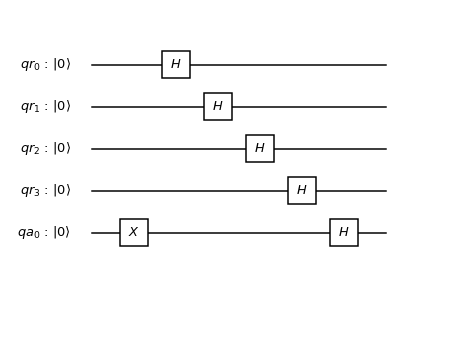

In [6]:
# define a circuit acting on qr and qa
prep = QuantumCircuit(qr, qa)

# Apply a "NOT aka bit-flip" (x) gate to ancilla qubit
# This prepares qa in state |1>
prep.x(qa)

#Apply a "hadamard" (h) gate to all qubits in qr and qa
prep.h(qr)
prep.h(qa)

circuit_drawer(prep)

## Specifying the oracle circuit
Next we must construct the quantum circuit that encodes the oracle for our chosen secret number. This may be done using 2-qubit entagling gates called Controlled-NOT (cx for short)

The Controlled-NOT has the following properties:
- if the first quibit is in the |0> state do nothing to the second qubit
- if the first qubit is in the |1> state apply an X gate to the second qubit

This can create entaglement

To implement the BV oracle we apply a cx gate to the ancilla for each qubit corresponding to the secret number having a 1 in its binary representation

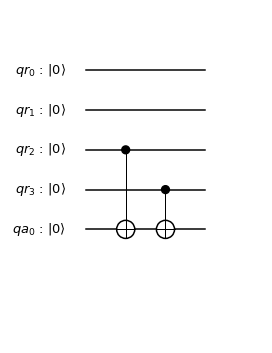

In [7]:
# secret number is 1100
oracle = QuantumCircuit(qr, qa)
oracle.cx(qr[2], qa[0])
oracle.cx(qr[3], qa[0])

circuit_drawer(oracle)

Rather than hardcoding the oracle we can define it for any input secret number

In [8]:
# Implement the oracle circuit for the given secret bitstring
oracle = QuantumCircuit(qr, qa)
for bit in range(number_of_bits):
    if secret_number & (2 ** bit):
        # if the bit value of the secret is 1
        # do a CNOT gate between that qubit and the ancilla
        oracle.cx(qr[bit], qa[0])

## Extracting data via measurement

To extract any information about the state of our quantum system we must perform measurements which store the outcome in classical bit values

A state in superposition has a probability of being measured in a 0 or 1 state corresponding to the square of its amplitude

Before measuring we must apply gates to measure in the correct basis, otherwise the outcome will be random. By applying a second round of Hadamard gates we undo the superposition to convert back to the standard basis.

In doing so we make use of a trick called phase kickback to encode the secret key into the qubit state. Applying Hadamard gates aroun d a CNOT gate has th following properties:

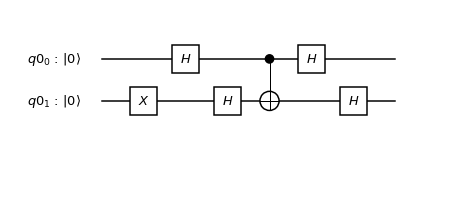

In [9]:
qr2 = QuantumRegister(2)
qc = QuantumCircuit(qr2)
qc.x(qr2[1])
qc.h(qr2)
qc.cx(qr2[0], qr2[1])
qc.h(qr2)
circuit_drawer(qc)

## Specifying the measurement circuit
Now that we have described why we chose the measurement circuit, we can implement it.

Measurement outcomes are stored using the ClassicalRegister class, and measure circuit method

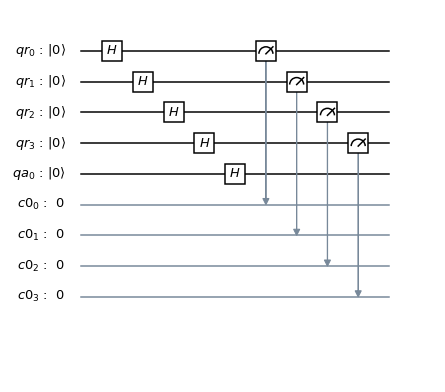

In [10]:
from qiskit import ClassicalRegister

# Define a 4-bit classical register to store measurements of qr
cr = ClassicalRegister(number_of_bits)

# Measurement sub-circuit
meas = QuantumCircuit(qr, qa, cr)

# apply H to all qubits
meas.h(qr)
meas.h(qa)

# measure data qubits
meas.measure(qr, cr)

circuit_drawer(meas, scale=0.5)

## Executing Circuits
To execute a circuit we must send it to a backend using the execute function. We can see what backends we have available using the available_backends function.

In [11]:
from qiskit import available_backends

available_backends()

['local_qasm_simulator',
 'local_statevector_simulator',
 'local_unitary_simulator']

## Executing circuits on local simulator
We will first execute our circuit on the local_qasm_simulator backend. This backend mimics an idealistic real quantum device without noise. 

The results are a dictionary of observed counts for the values of the classical registers. We may view them using the plot_histogram visualization function.

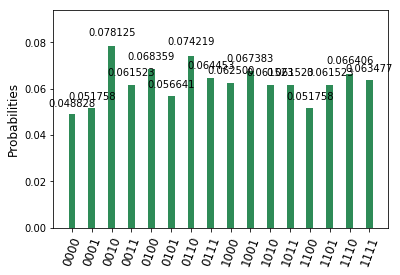

In [12]:
from qiskit import execute
from qiskit.tools.visualization import plot_histogram

# execute on local simulator and retrieve results
sim_result = execute(meas, 'local_qasm_simulator').result()
sim_counts = sim_result.get_counts() # get count dict
plot_histogram(sim_counts) # plot count dict

## Execute on an IBM-Q quantum computer
To execute on a real device you need to register for an API token for IBM-Q backends. This allows sending jobs for execution to the IBM-Q cloud. 

In [ ]:
from qiskit import register
import Qconfig

register(Qconfig.APItoken)

available_backends()

Let's execute on the 5-qubit IBM-Q Tenerife (ibmqx4) device
We may select a device for execution using get_backend function


In [ ]:
from qiskit import get_backend

device = get_backend('ibmqx4')
job = execute(meas, device)

### Monitoring execution progress
We can use the job API to monitor our execution states on the remote backend. The following is an example of a function which uses this API to do this.

In [ ]:
import time
job_poll_interval = 10
lapse = 0
while not job.done:
    try: 
        print('Queueing...')
    expect:
        print('')
    time.sleep(job_poll_interval)
    lapse =+1

### Getting results from remote job

Once the JobStatus is finished we can extract our results from the real device and view them

In [ ]:
device_result = job.result()
device_counts = device_result.get_counts()
plot_histogram(device_counts)

## And We're Done!